# Activity Investigation

This should be helpful when I just want to look closely at the results of a particular activity stream

In [226]:
from strava.data.cache import Cache
from strava.data.strava_requests import *
from strava.plotting.strava_annual_plots import *
from strava.plotting.strava_stream_plots import *
from generate_plots import get_clean_activities, get_clean_stream
from strava.data.cache import Cache

import aiohttp
import asyncio
import copy
from datetime import date
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import pandas as pd
from pandas_profiling import ProfileReport
from plotnine import ggplot, aes
import plotnine as gg
import time
from typing import List
import urllib3
import PIL
from PIL import Image
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
gg.options.figure_size = (11, 8.5)
pt.dark()

pd.set_option('display.max_columns', 500)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Create a cache
cache = Cache()

In [115]:
# Get a list of activities
activities = get_clean_activities()
activities.tail()

Existing access token is valid.
Beginning request of activities...
-> Received page 1 with 200 activities.
-> Received page 2 with 200 activities.
-> Received page 3 with 181 activities.
-> Received page 4 with 0 activities.
...retrieved total of 581 activities.


,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
575,3425015993,Afternoon Ride,8964.6,0 days 00:26:43,0 days 00:26:43,39.0,693.8,654.7,Ride,2020-04-26 15:07:20,(GMT-07:00) America/Edmonton,"[53.636688, -113.587822]","[53.636729, -113.587903]",0,a3425015993,10.0,20.1312,40.32,165.0,185.0,{mjfIhhjtTt@fAf@|@HREZUpAe@pB{@vC]z@a@r@k@x@c@...,2020,1970-04-26 15:07:20
576,3425016238,Lunch Ride,17516.8,0 days 00:48:11,0 days 00:48:11,71.2,693.8,653.7,Ride,2020-04-25 11:48:43,(GMT-07:00) America/Edmonton,"[53.636724, -113.587843]","[53.636742, -113.587806]",0,a3425016238,10.0,21.8124,50.04,178.0,194.0,knjfIrhjtT`AxAb@v@G|@UvA[pAw@fCy@hBg@t@g@l@u@n...,2020,1970-04-25 11:48:43
577,3425017204,Afternoon Ride,14517.0,0 days 00:47:28,0 days 00:47:28,64.1,693.8,653.7,Ride,2020-04-23 13:02:13,(GMT-07:00) America/Edmonton,"[53.636938, -113.587945]","[53.636747, -113.58785]",0,a3425017204,10.0,18.3492,36.72,175.4,198.0,qnjfIlhjtTfAvAl@bAEp@OdA]hBc@lBW~@]~@Yj@g@t@_@...,2020,1970-04-23 13:02:13
578,3425016478,Afternoon Ride,17605.8,0 days 00:57:41,0 days 00:57:41,69.9,693.8,653.7,Ride,2020-04-22 14:48:16,(GMT-07:00) America/Edmonton,"[53.636929, -113.587659]","[53.636694, -113.587956]",0,a3425016478,10.0,18.3132,39.96,176.6,194.0,wmjfIdhjtTx@pAZv@F^?XAb@EZUt@[r@qBpCw@rA_@b@s@...,2020,1970-04-22 14:48:16
580,3425016348,Afternoon Ride,7278.0,0 days 00:23:28,0 days 00:23:28,21.9,693.8,684.9,Ride,2020-04-16 13:57:58,(GMT-07:00) America/Edmonton,"[53.636894, -113.587782]","[53.636646, -113.587864]",0,a3425016348,10.0,18.6084,36.00,177.8,197.0,uojfIxhjtTvB|CjAnBbApBlA|CXdC^tEL`CB|ACtBKjBs@...,2020,1970-04-16 13:57:58


In [214]:
# Select only specific activities
cres = activities.query('year == 2023 & distance < 28900 & distance > 28200')
cres = activities.query('year == 2023')
cres = activities.query('year != 2023')
print(cres.shape)
cres.head(15)

(334, 23)


,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
0,11214280814,Collision special,20172.3,0 days 00:52:49,34 days 03:57:33,235.7,101.1,3.5,Ride,2024-03-15 16:32:46,(GMT-08:00) America/Vancouver,"[49.05513323843479, -122.77457839809358]","[49.05696954578161, -122.85631871782243]",0,a11214280814,10.0,22.9176,57.0528,176.5,193.0,caljH|tjlVXfANR\Ed@g@D@P^ZpBLj@^dAL`Bb@bA@l@JP...,2024,1970-03-15 16:32:46
12,10818058984,Pre-Season Testing,11187.5,0 days 00:29:14,0 days 00:30:53,109.6,103.1,52.1,Ride,2024-02-22 16:44:42,(GMT-08:00) America/Vancouver,"[49.055141704156995, -122.7743905596435]","[49.055102141574025, -122.77465936727822]",2,a10818058984,10.0,22.9608,41.3640,170.0,188.0,{aljHjtjlV\nANXJHFBHEJ_@`@a@D?PV?`ADh@THVzAF`@...,2024,1970-02-22 16:44:42
240,8045313875,Afternoon Ride,21108.4,0 days 00:46:06,0 days 00:48:02,96.9,694.2,652.5,Ride,2022-10-30 16:04:34,(GMT-07:00) America/Edmonton,"[53.636792, -113.587991]","[53.636679, -113.587848]",0,a8045313875,0.0,27.4716,53.0100,171.9,188.0,anjfIjhjtT~@nAz@zAXdB_ArDe@^kCfIiACkA~BoA?i@d@...,2022,1970-10-30 16:04:34
241,8029717831,Afternoon Ride,22332.2,0 days 00:49:20,0 days 00:53:29,108.7,694.2,652.7,Ride,2022-10-27 16:30:50,(GMT-07:00) America/Edmonton,"[53.636723, -113.588211]","[53.636826, -113.587827]",1,a8029717831,0.0,27.1620,52.3440,174.6,189.0,anjfIjhjtTdB~BRdAG^mC~JQLWlA[b@gAr@gAjA}BMaAh@...,2022,1970-10-27 16:30:50
243,7989629345,Afternoon Ride,36327.6,0 days 01:18:55,0 days 01:21:06,170.1,694.2,652.7,Ride,2022-10-19 13:55:06,(GMT-07:00) America/Edmonton,"[53.636782, -113.588179]","[53.636679, -113.587972]",0,a7989629345,0.0,27.6192,54.6660,169.9,185.0,ymjfIphjtTtBtD{@`Du@`AiAjFk@lAu@FyAvBuAFaDdBmD...,2022,1970-10-19 13:55:06
244,7984626977,Afternoon Ride,36699.0,0 days 01:19:18,0 days 01:22:17,179.0,694.2,652.7,Ride,2022-10-18 14:31:27,(GMT-07:00) America/Edmonton,"[53.636958, -113.588695]","[53.636802, -113.587855]",2,a7984626977,0.0,27.7668,52.4376,172.1,188.0,gnjfIphjtTtBpCRdAOv@u@x@eClJqCbDu@K{@HuAz@gFqA...,2022,1970-10-18 14:31:27
245,7979165627,Afternoon Ride,17654.1,0 days 00:37:32,0 days 00:39:37,78.6,694.2,652.7,Ride,2022-10-17 14:31:25,(GMT-07:00) America/Edmonton,"[53.63673, -113.58799]","[53.636715, -113.587875]",1,a7979165627,0.0,28.2204,51.0552,172.9,190.0,cnjfIvhjtTrA~Ah@`A?z@c@v@yBrIWXc@|Ae@bA{AdBQ[S...,2022,1970-10-17 14:31:25
246,7974839294,Afternoon Ride,42180.9,0 days 01:34:03,0 days 01:35:52,233.0,694.2,652.7,Ride,2022-10-16 14:45:05,(GMT-07:00) America/Edmonton,"[53.636757, -113.587916]","[53.63677, -113.587778]",0,a7974839294,0.0,26.9100,49.1652,170.3,187.0,ymjfIjhjtTpBlCJr@kFbPwCpBqBDuAdByEoCsCPoCnCgBp...,2022,1970-10-16 14:45:05
247,7949009585,Afternoon Ride,22515.8,0 days 00:49:51,0 days 00:52:05,109.4,694.2,652.7,Ride,2022-10-11 15:55:17,(GMT-07:00) America/Edmonton,"[53.63657020032406, -113.58801176771522]","[53.63678050227463, -113.58794563449919]",1,a7949009585,NaN,27.1008,53.4024,170.5,190.0,injfIthjtTvBfCNv@eClJg@t@o@jBgAf@_CnBkA@{B~@wA...,2022,1970-10-11 15:55:17
248,7928110779,Afternoon Ride,42820.4,0 days 01:31:41,0 days 01:36:26,267.7,694.2,650.1,Ride,2022-10-07 13:44:16,(GMT-07:00) America/Edmonton,"[53.63675703294575, -113.5878349095583]","[53.63683347590268, -113.58797354623675]",3,a7928110779,NaN,28.0224,52.4808,171.5,192.0,ymjfIthjtTbCfEwBnEqBvHiDhCeEb@{FcBmCPwBdBUtBLh...,2022,1970-10-07 13:44:16


/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 40'. Pick better value with 'binwidth'.


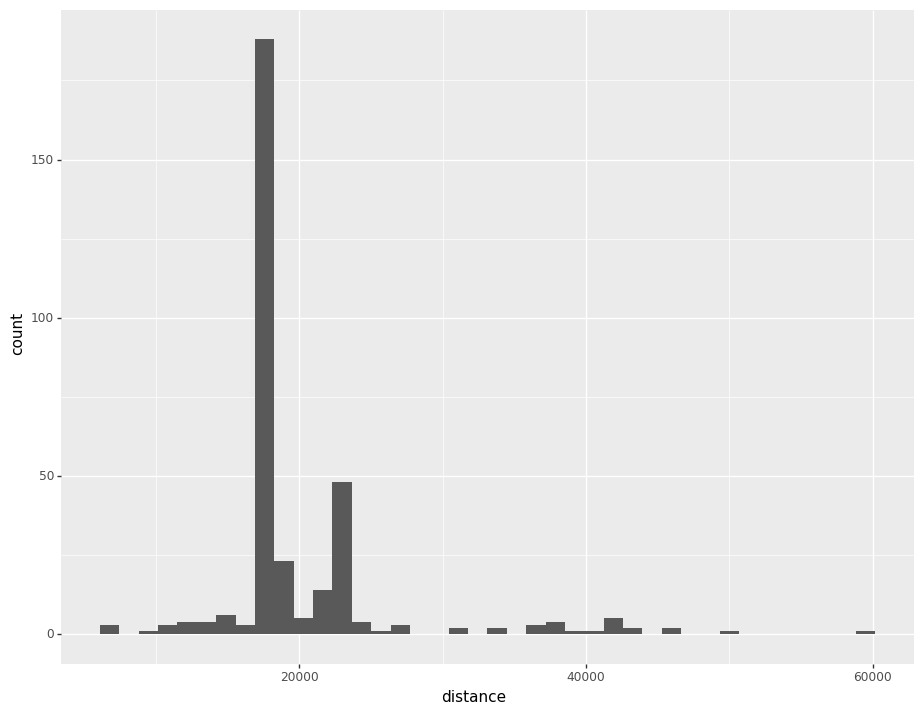

<ggplot: (1148862047)>

In [215]:
# description of the distance of all of these activities
(gg.ggplot(cres, gg.aes(x='distance')) + gg.geom_histogram())

In [229]:
# Request the full streams for all of the activities
cres_act = []
for da in cres.start_date_local.apply(lambda x: x.date()):
    cres_act.append(get_clean_stream(activities, da, cache))
cres_act = pd.concat(cres_act)

Found activity 11214280814 in cache.
Found activity 10818058984 in cache.
Found activity 8045313875 in cache.
Found activity 8029717831 in cache.
Found activity 7989629345 in cache.
Found activity 7984626977 in cache.
Found activity 7979165627 in cache.
Found activity 7974839294 in cache.
Found activity 7949009585 in cache.
Found activity 7928110779 in cache.
Found activity 7916199658 in cache.
Found activity 7912211536 in cache.
Found activity 7902692512 in cache.
Found activity 7891643987 in cache.
Found activity 7881885385 in cache.
Found activity 7876973997 in cache.
Found activity 7871826303 in cache.
Found activity 7867107223 in cache.
Found activity 7856084651 in cache.
Found activity 7851318149 in cache.
Found activity 7846546196 in cache.
Found activity 7830749817 in cache.
Found activity 7819087887 in cache.
Found activity 7809467855 in cache.
Found activity 7804080763 in cache.
Found activity 7798391014 in cache.
Found activity 7787348827 in cache.
Found activity 7781689276 

In [230]:
cres_act.head(15)

,moving,latlng,velocity,distance,altitude,heartrate,time,id
0,False,"[49.055133, -122.774578]",0.0000,3.8,56.8,136,0,11214280814
1,False,"[49.055113, -122.774508]",0.0000,3.8,56.5,136,1,11214280814
2,False,"[49.05512, -122.774457]",0.0000,3.8,56.4,136,2,11214280814
3,True,"[49.055129, -122.774448]",1.4040,4.9,56.3,136,3,11214280814
4,True,"[49.055142, -122.774466]",2.8548,6.9,56.2,136,4,11214280814
5,True,"[49.055162, -122.774456]",3.9816,9.3,56.1,133,5,11214280814
6,True,"[49.055167, -122.774395]",7.2360,13.8,56.0,133,6,11214280814
7,True,"[49.055182, -122.774333]",10.6704,18.6,55.8,133,7,11214280814
8,True,"[49.055223, -122.774291]",13.8168,24.1,55.5,133,8,11214280814
9,True,"[49.055269, -122.774261]",16.3296,29.6,55.3,133,9,11214280814


In [231]:
# Separate the latitude and longitude into their own columns
cres_act['lat'] = cres_act.latlng.apply(lambda x: x[0])
cres_act['lng'] = cres_act.latlng.apply(lambda x: x[1])

In [232]:
# Smooth out the velocity for graphing
smoothing_window = 20
cres_act['vel_smooth'] = cres_act.groupby('id')['velocity'].transform(lambda x: x.rolling(smoothing_window, center=True).mean())
cres_act['vel_smooth'].head(20)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10    15.96798
11    17.45838
12    18.92790
13    20.32578
14    21.63222
15    22.84380
16    23.98896
17    24.98904
18    25.84692
19    26.54676
Name: vel_smooth, dtype: float64

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 19 rows containing missing values.


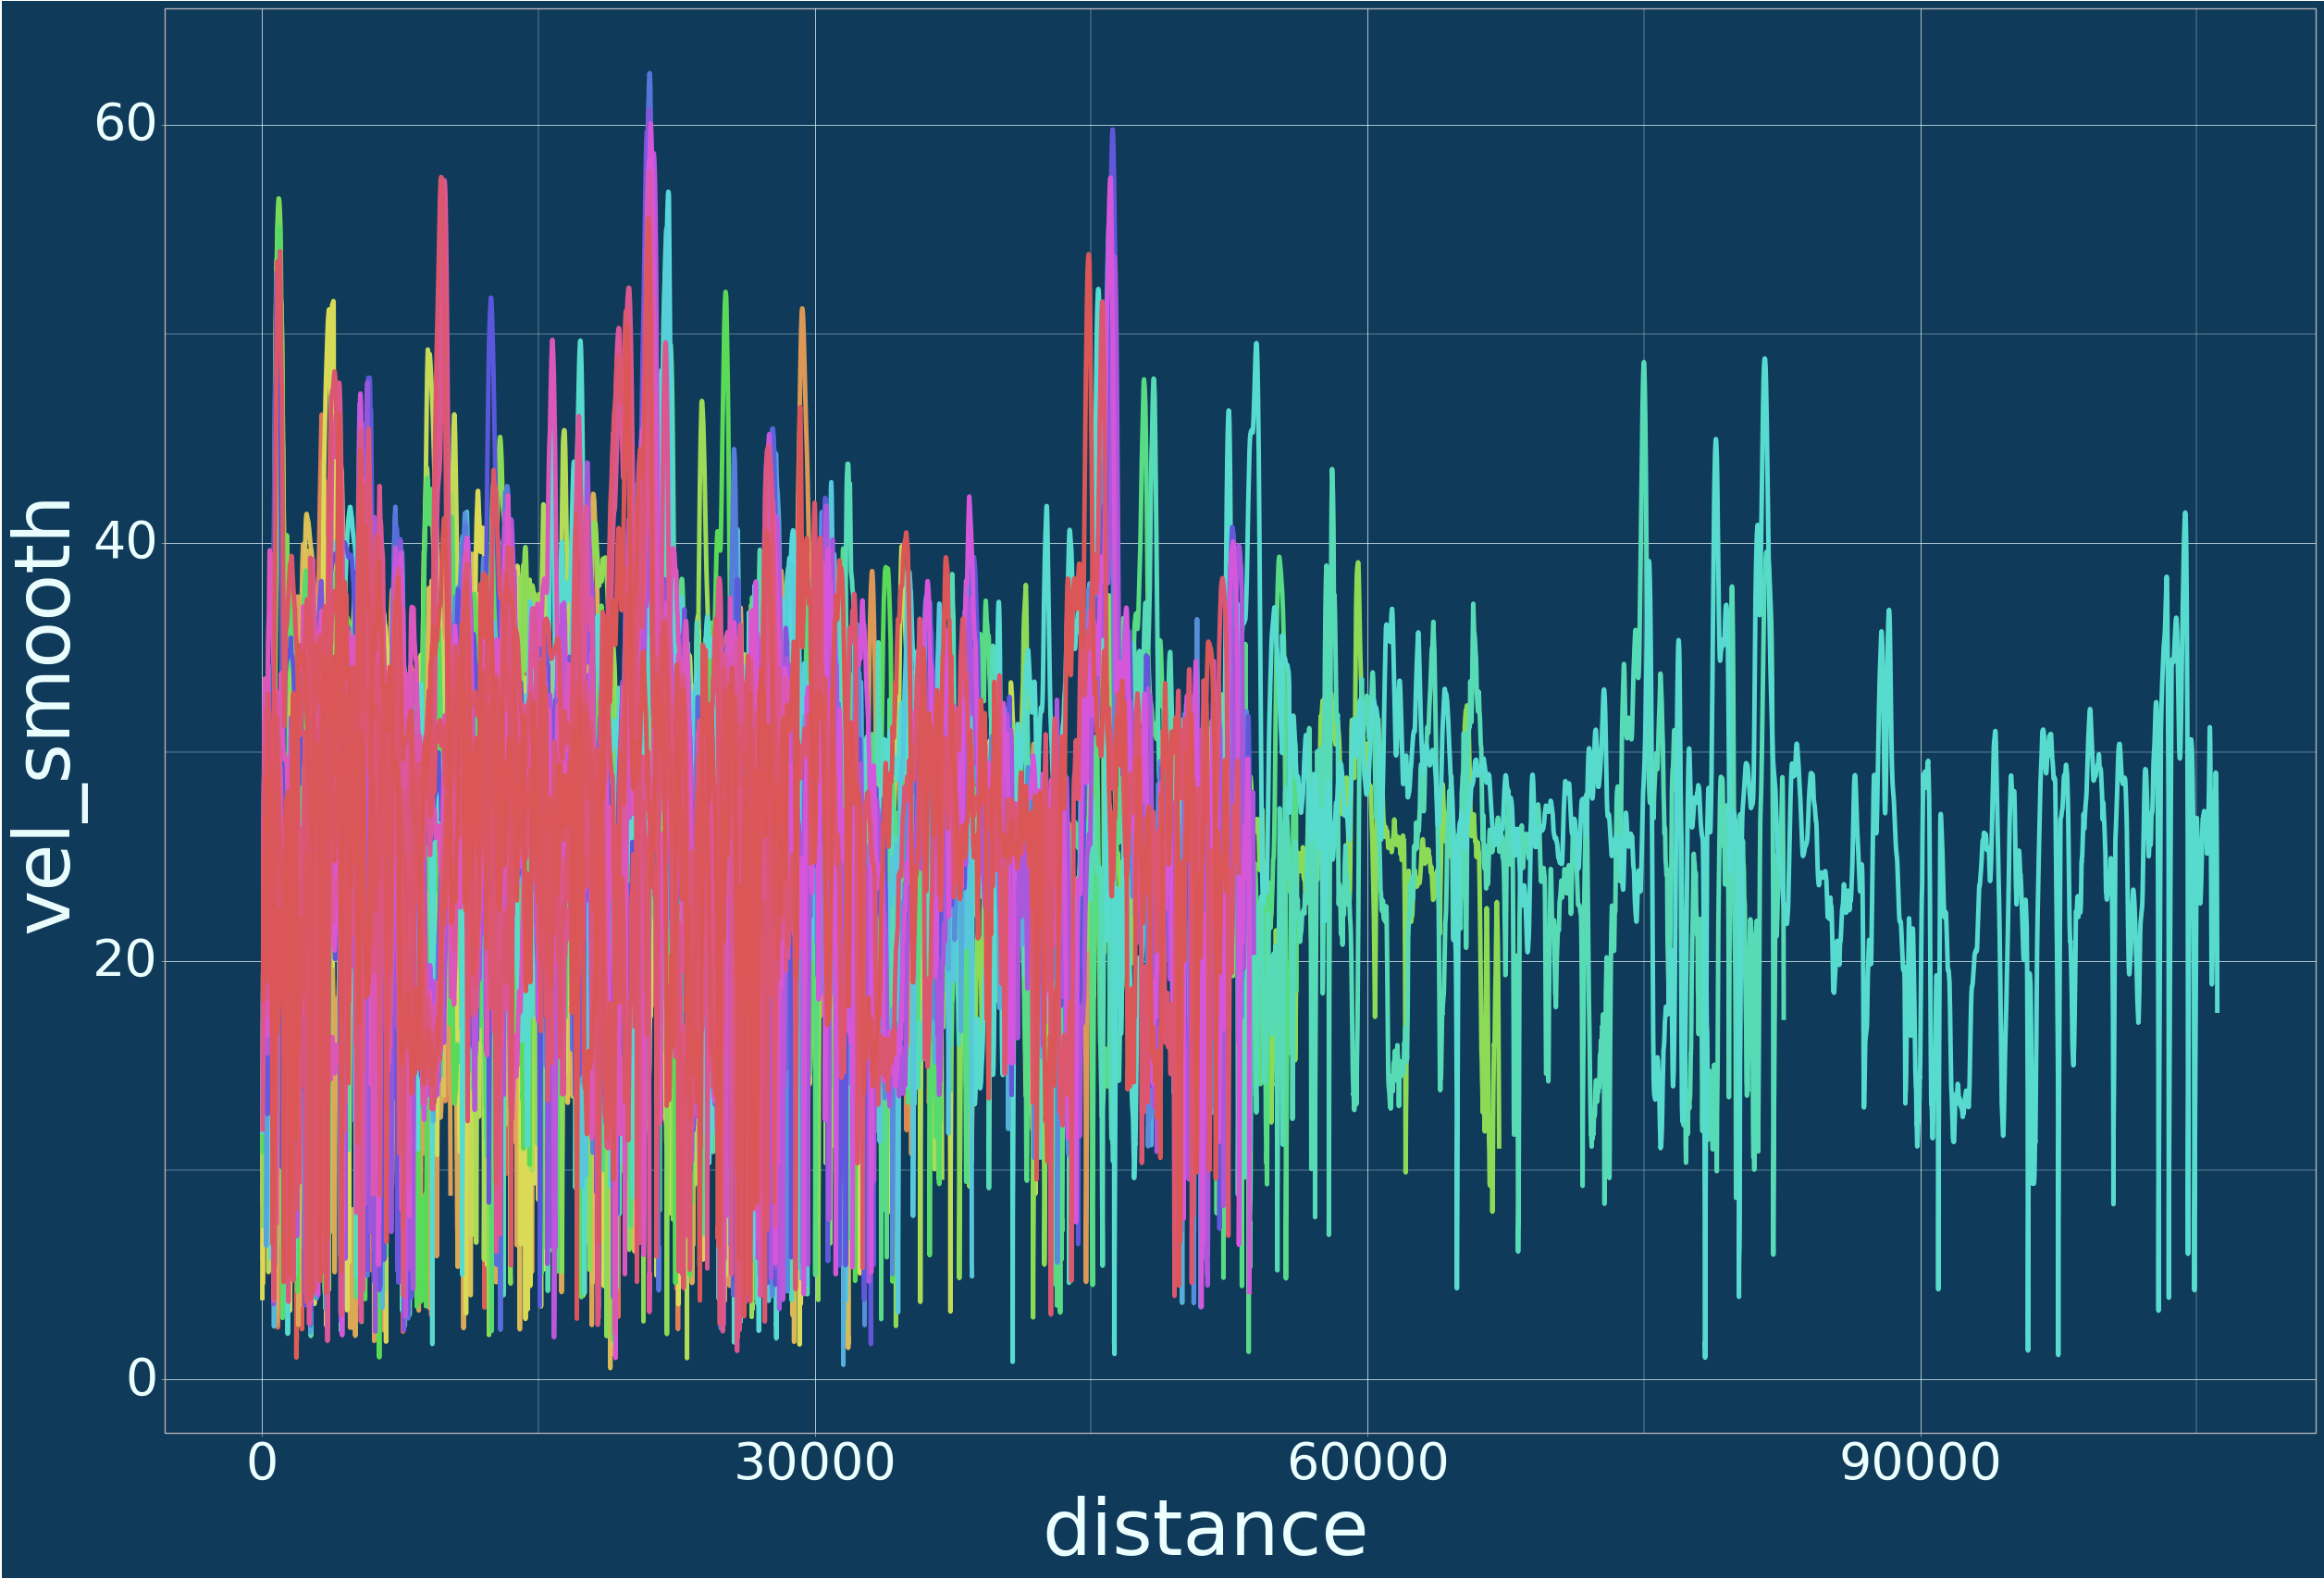

<ggplot: (885707918)>

In [187]:
# smoothed velocity over distance
pt.dark()
(gg.ggplot(cres_act, gg.aes(x='distance', y='vel_smooth', colour='factor(id)')) 
    + gg.geom_line(size=2)
    + gg.theme(figure_size=(20, 15))
    # + gg.scale_x_continuous(limits=[13000, 22000])
    + gg.scale_colour_discrete(guide=False)
    + pt.gg_theme()
    )

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 4892 rows containing missing values.


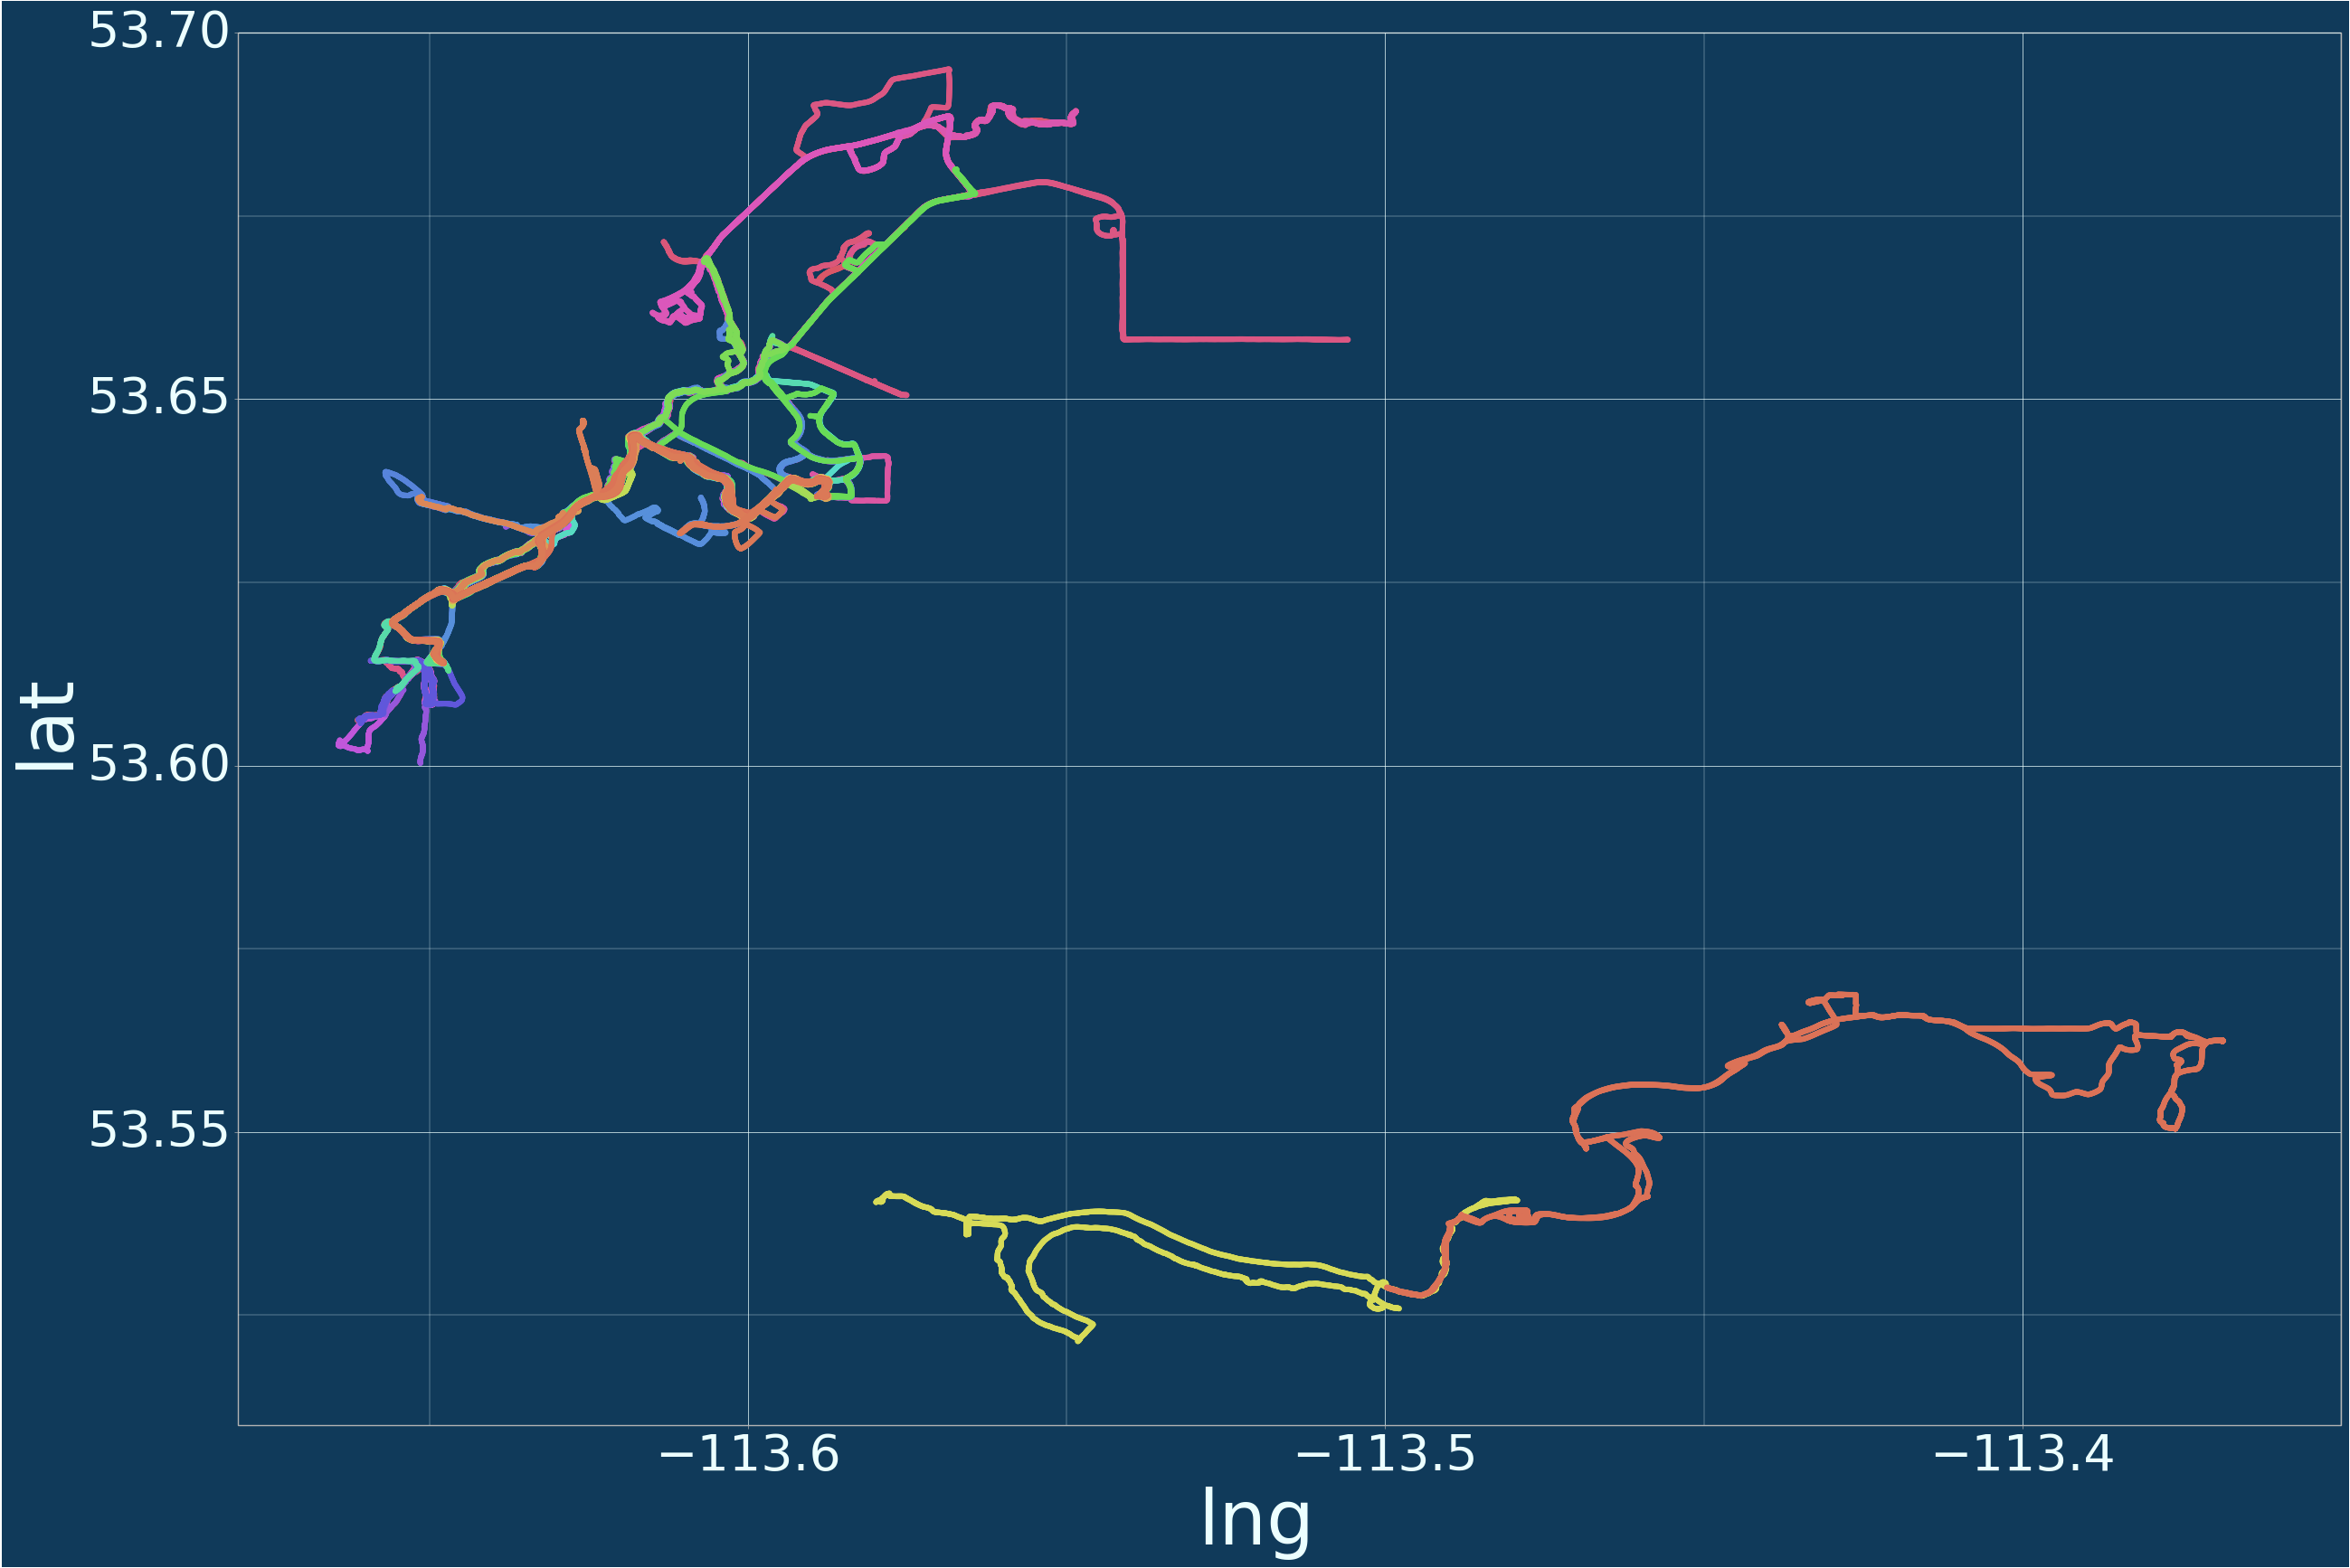

<ggplot: (856073030)>

In [244]:
# Plot of the route
# These are for crescent Beach
# xmin = 49.045
# xmax = 49.06
# ymin = -122.9
# ymax = -122.87
# Lower Mainland
# ymin = 48.99
# ymax = 49.13
# xmin = -122.9
# xmax = -122.48
# Edmonton
ymin = 53.51
ymax = 53.7
xmin = -113.68
xmax = -113.35
scale = 5
pt.dark()
(gg.ggplot(cres_act, gg.aes(x='lng', y='lat', colour='factor(id)')) 
    + gg.geom_point()
    + gg.theme(figure_size=[1 * scale, abs((ymax - ymin)/(xmax-xmin)) * scale])
    + gg.scale_x_continuous(limits=[xmin, xmax], expand=[0, 0])
    + gg.scale_y_continuous(limits=[ymin, ymax], expand=[0, 0])
    + gg.scale_colour_discrete(guide=False)
    + pt.gg_theme()
    )

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 27239 rows containing missing values.


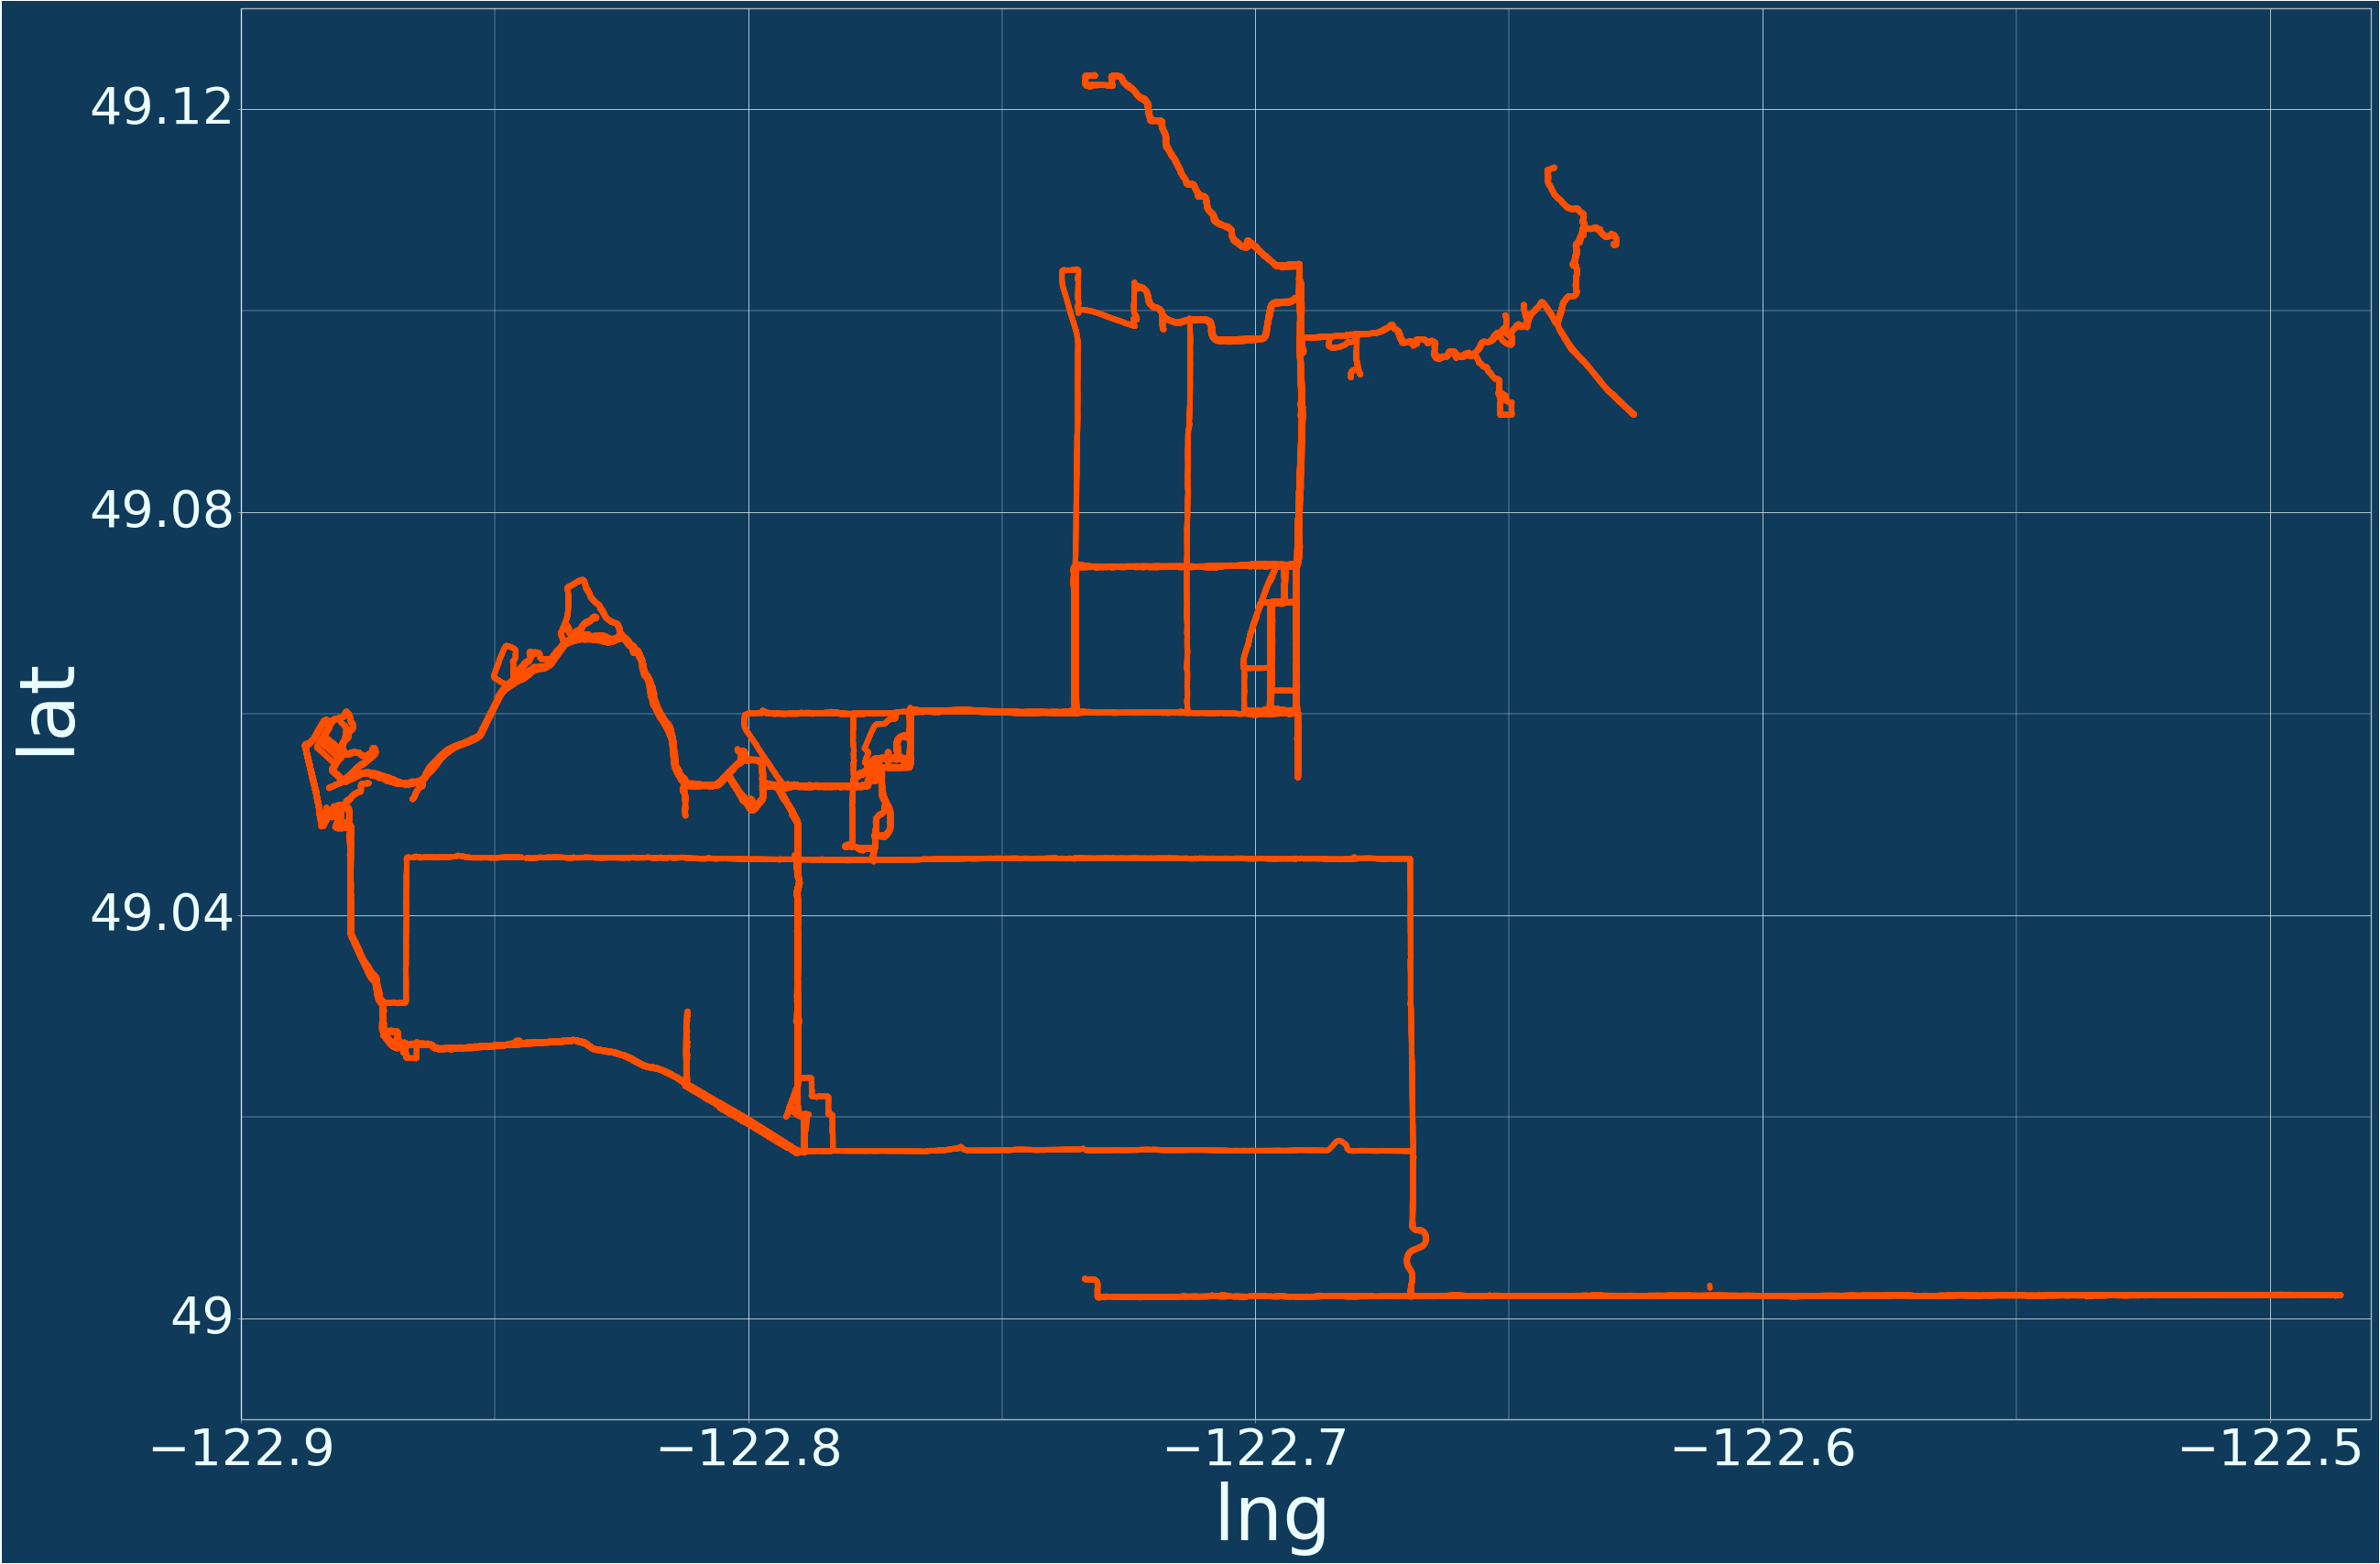

<ggplot: (1105233431)>

In [213]:
# Plot of the route
# These are for crescent Beach
# xmin = 49.045
# xmax = 49.06
# ymin = -122.9
# ymax = -122.87
# Regular Ride
ymin = 48.99
ymax = 49.13
xmin = -122.9
xmax = -122.48
scale = 5
pt.dark()
(gg.ggplot(cres_act, gg.aes(x='lng', y='lat', group='id')) 
    + gg.geom_point(colour='#ff4f00')
    + gg.theme(figure_size=[1 * scale, abs((ymax - ymin)/(xmax-xmin)) * scale])
    + gg.scale_x_continuous(limits=[xmin, xmax], expand=[0, 0])
    + gg.scale_y_continuous(limits=[ymin, ymax], expand=[0, 0])
    # + gg.scale_colour_discrete(guide=False)
    + pt.gg_theme()
    )